In [1]:
import os
import sys

In [2]:
sys.path.append("..")

In [3]:
import numpy as np

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
from tqdm import tqdm
from collections import defaultdict

In [6]:
import glob

In [7]:
import matplotlib.pyplot as plt

In [8]:
!mkdir -p saved
!cp ../saved/plda_xvector.npz saved

In [9]:
embeddings_path = "/home/alexey/Documents/python/household/embeddings"

In [10]:
torch.manual_seed(42)
np.random.seed(42)

# VoxCeleb1

In [11]:
data = np.load(f"{embeddings_path}/emb_vox1_train_xvector_trimmed.npz")

# data = np.load(f'{embeddings_path}/emb_asvspoof2019_train_xvector.npz')
# X = data['X']
# utt_ids = data['ids']
# classes, y = np.unique(utt_ids, return_inverse=True)

X = torch.tensor(data['X'])
y = torch.tensor(data['y'])

classes, _ = torch.unique(y, return_inverse=True)
print('classes:', len(classes))
print(X.shape, y.shape)  

classes: 1211
torch.Size([148642, 512]) torch.Size([148642])


In [12]:
from utils import generate_trials

n_tar, n_imp = 10000, 10000

trials_1vs1, labels_1vs1 = generate_trials(y, n_tar, n_imp, n_enrolls=1, n_tests=1, seed=0)
trials_3vs1, labels_3vs1 = generate_trials(y, n_tar, n_imp, n_enrolls=3, n_tests=1, seed=1)
trials_10vs1, labels_10vs1 = generate_trials(y, n_tar, n_imp, n_enrolls=10, n_tests=1, seed=2)

In [13]:
from scoring import *
from preprocessing import *
from utils import requires_grad
from metrics import eer

In [14]:
preprocessing_name = "xvector"
transforms, model_params = load_backend(preprocessing_name)
X = apply_sequence(X, transforms) 

100%|██████████| 20000/20000 [00:04<00:00, 4016.98it/s]


EER, averaging, pooled: 2.37 %
EER, averaging, 1 enroll: 2.45 %
EER, averaging, 3 enrolls: 1.10 %
EER, averaging, 10 enrolls: 0.70 %


100%|██████████| 20000/20000 [00:05<00:00, 3888.43it/s]


EER, by_the_book, pooled: 1.48 %
EER, by_the_book, 1 enroll: 2.45 %
EER, by_the_book, 3 enrolls: 1.19 %
EER, by_the_book, 10 enrolls: 0.78 %


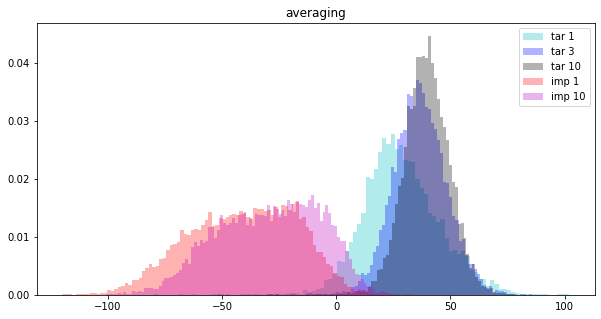

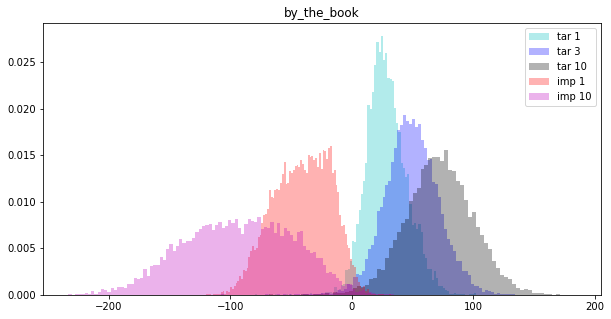

In [15]:
for score_type in ["averaging", "by_the_book"]:
    
    # load pretrained PLDA
    w_vec = model_params['W']
    w_vec = torch.tensor(w_vec).float()
    similarity_score = ScoreDiagPLDA(w_vec, by_the_book=score_type=="by_the_book")

    requires_grad(similarity_score, False)

    # compute scores
    # 1 enroll
    scores_1vs1 = []
    for (idx_enr, idx_test) in tqdm(trials_1vs1):

        x_enr = X[idx_enr]
        x_test = X[idx_test:idx_test+1]

        n_e = x_enr.shape[0]
        c_e = torch.mean(x_enr, dim=0, keepdim=True)
        score = similarity_score((c_e, n_e), x_test)
        #score = similarity_score(x_enr, x_test)
        scores_1vs1 += [score]

    scores_1vs1 = torch.cat(scores_1vs1)
    scores_1vs1 = scores_1vs1.cpu().numpy()

    # 3 enrolls
    scores_3vs1 = []
    for (idx_enr, idx_test) in tqdm(trials_3vs1):

        x_enr = X[idx_enr]
        x_test = X[idx_test:idx_test+1]

        n_e = x_enr.shape[0]
        c_e = torch.mean(x_enr, dim=0, keepdim=True)
        score = similarity_score((c_e, n_e), x_test)
        #score = similarity_score(x_enr, x_test)
        scores_3vs1 += [score]

    scores_3vs1 = torch.cat(scores_3vs1)
    scores_3vs1 = scores_3vs1.cpu().numpy()

    #10 enrolls
    scores_10vs1 = []
    for (idx_enr, idx_test) in tqdm(trials_10vs1):

        x_enr = X[idx_enr]
        x_test = X[idx_test:idx_test+1]

        n_e = x_enr.shape[0]
        c_e = torch.mean(x_enr, dim=0, keepdim=True)
        score = similarity_score((c_e, n_e), x_test)
        #score = similarity_score(x_enr, x_test)
        scores_10vs1 += [score]

    scores_10vs1 = torch.cat(scores_10vs1)
    scores_10vs1 = scores_10vs1.cpu().numpy()

    # compute EER
    EER, _ = eer(np.r_[scores_1vs1, scores_3vs1, scores_10vs1], np.r_[labels_1vs1, labels_3vs1, labels_10vs1])
    #EER, _ = eer(np.r_[scores_1vs1, scores_10vs1], np.r_[labels_1vs1, labels_10vs1])
    print(f'EER, {score_type}, pooled: {100*EER:.2f} %') 
    EER, _ = eer(scores_1vs1, labels_1vs1)
    print(f'EER, {score_type}, 1 enroll: {100*EER:.2f} %')
    EER, _ = eer(scores_3vs1, labels_3vs1)
    print(f'EER, {score_type}, 3 enrolls: {100*EER:.2f} %')
    EER, _ = eer(scores_10vs1, labels_10vs1)
    print(f'EER, {score_type}, 10 enrolls: {100*EER:.2f} %')


    plt.figure(figsize=(10,5))
    n_bins = 100
    plt.hist(scores_1vs1[labels_1vs1==1], bins=n_bins, color='c', density=True, alpha=0.3, label='tar 1');
    plt.hist(scores_3vs1[labels_3vs1==1], bins=n_bins, color='b', density=True, alpha=0.3, label='tar 3');
    plt.hist(scores_10vs1[labels_10vs1==1], bins=n_bins, color='k', density=True, alpha=0.3, label='tar 10');
    plt.hist(scores_1vs1[labels_1vs1==0], bins=n_bins, color='r', density=True, alpha=0.3, label='imp 1');
    plt.hist(scores_10vs1[labels_10vs1==0], bins=n_bins, color='m', density=True, alpha=0.3, label='imp 10');
    plt.title(f'{score_type}');
    
    plt.legend();


# ASVspoof

In [16]:
#data = np.load(f"{embeddings_path}/emb_vox1_train_xvector_trimmed.npz")

data = np.load(f'{embeddings_path}/emb_asvspoof2019_train_xvector.npz')
X = data['X']
utt_ids = data['ids']
classes, y = np.unique(utt_ids, return_inverse=True)

X = torch.tensor(data['X'])
y = torch.tensor(data['y'])

classes, _ = torch.unique(y, return_inverse=True)
print('classes:', len(classes))
print(X.shape, y.shape)  

classes: 20
torch.Size([5400, 512]) torch.Size([5400])


In [17]:
from utils import generate_trials

n_tar, n_imp = 10000, 10000

trials_1vs1, labels_1vs1 = generate_trials(y, n_tar, n_imp, n_enrolls=1, n_tests=1, seed=0)
trials_3vs1, labels_3vs1 = generate_trials(y, n_tar, n_imp, n_enrolls=3, n_tests=1, seed=1)
trials_10vs1, labels_10vs1 = generate_trials(y, n_tar, n_imp, n_enrolls=10, n_tests=1, seed=2)

In [18]:
from scoring import *
from preprocessing import *
from utils import requires_grad
from metrics import eer

In [19]:
preprocessing_name = "xvector"
transforms, model_params = load_backend(preprocessing_name)
X = apply_sequence(X, transforms) 

100%|██████████| 20000/20000 [00:05<00:00, 3740.14it/s]


EER, averaging, pooled: 6.93 %
EER, averaging, 1 enroll: 8.33 %
EER, averaging, 3 enrolls: 4.28 %
EER, averaging, 10 enrolls: 1.75 %


100%|██████████| 20000/20000 [00:05<00:00, 3660.02it/s]


EER, by_the_book, pooled: 9.90 %
EER, by_the_book, 1 enroll: 8.33 %
EER, by_the_book, 3 enrolls: 5.26 %
EER, by_the_book, 10 enrolls: 2.82 %


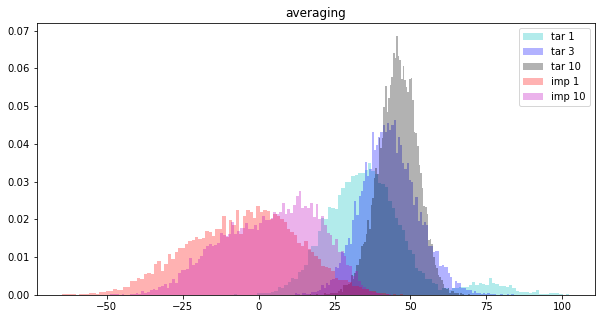

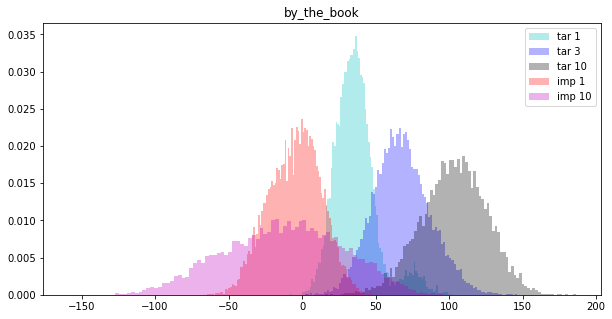

In [20]:
for score_type in ["averaging", "by_the_book"]:
    
    # load pretrained PLDA
    w_vec = model_params['W']
    w_vec = torch.tensor(w_vec).float()
    similarity_score = ScoreDiagPLDA(w_vec, by_the_book=score_type=="by_the_book")

    requires_grad(similarity_score, False)

    # compute scores
    # 1 enroll
    scores_1vs1 = []
    for (idx_enr, idx_test) in tqdm(trials_1vs1):

        x_enr = X[idx_enr]
        x_test = X[idx_test:idx_test+1]

        n_e = x_enr.shape[0]
        c_e = torch.mean(x_enr, dim=0, keepdim=True)
        score = similarity_score((c_e, n_e), x_test)
        #score = similarity_score(x_enr, x_test)
        scores_1vs1 += [score]

    scores_1vs1 = torch.cat(scores_1vs1)
    scores_1vs1 = scores_1vs1.cpu().numpy()

    # 3 enrolls
    scores_3vs1 = []
    for (idx_enr, idx_test) in tqdm(trials_3vs1):

        x_enr = X[idx_enr]
        x_test = X[idx_test:idx_test+1]

        n_e = x_enr.shape[0]
        c_e = torch.mean(x_enr, dim=0, keepdim=True)
        score = similarity_score((c_e, n_e), x_test)
        #score = similarity_score(x_enr, x_test)
        scores_3vs1 += [score]

    scores_3vs1 = torch.cat(scores_3vs1)
    scores_3vs1 = scores_3vs1.cpu().numpy()

    #10 enrolls
    scores_10vs1 = []
    for (idx_enr, idx_test) in tqdm(trials_10vs1):

        x_enr = X[idx_enr]
        x_test = X[idx_test:idx_test+1]

        n_e = x_enr.shape[0]
        c_e = torch.mean(x_enr, dim=0, keepdim=True)
        score = similarity_score((c_e, n_e), x_test)
        #score = similarity_score(x_enr, x_test)
        scores_10vs1 += [score]

    scores_10vs1 = torch.cat(scores_10vs1)
    scores_10vs1 = scores_10vs1.cpu().numpy()

    # compute EER
    EER, _ = eer(np.r_[scores_1vs1, scores_3vs1, scores_10vs1], np.r_[labels_1vs1, labels_3vs1, labels_10vs1])
    #EER, _ = eer(np.r_[scores_1vs1, scores_10vs1], np.r_[labels_1vs1, labels_10vs1])
    print(f'EER, {score_type}, pooled: {100*EER:.2f} %') 
    EER, _ = eer(scores_1vs1, labels_1vs1)
    print(f'EER, {score_type}, 1 enroll: {100*EER:.2f} %')
    EER, _ = eer(scores_3vs1, labels_3vs1)
    print(f'EER, {score_type}, 3 enrolls: {100*EER:.2f} %')
    EER, _ = eer(scores_10vs1, labels_10vs1)
    print(f'EER, {score_type}, 10 enrolls: {100*EER:.2f} %')


    plt.figure(figsize=(10,5))
    n_bins = 100
    plt.hist(scores_1vs1[labels_1vs1==1], bins=n_bins, color='c', density=True, alpha=0.3, label='tar 1');
    plt.hist(scores_3vs1[labels_3vs1==1], bins=n_bins, color='b', density=True, alpha=0.3, label='tar 3');
    plt.hist(scores_10vs1[labels_10vs1==1], bins=n_bins, color='k', density=True, alpha=0.3, label='tar 10');
    plt.hist(scores_1vs1[labels_1vs1==0], bins=n_bins, color='r', density=True, alpha=0.3, label='imp 1');
    plt.hist(scores_10vs1[labels_10vs1==0], bins=n_bins, color='m', density=True, alpha=0.3, label='imp 10');
    plt.title(f'{score_type}');
    
    plt.legend();
